Loading dataset **Conll2003** with four classes: **Per**, **Org**, **Loc** and **Misc** in Conll format.

In [1]:
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train

--2021-06-05 08:22:43--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827012 (808K) [text/plain]
Saving to: ‘eng.testa’

eng.testa           100%[===================>] 807.63K  --.-KB/s    in 0.03s   

2021-06-05 08:22:43 (23.4 MB/s) - ‘eng.testa’ saved [827012/827012]

--2021-06-05 08:22:43--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3281528 (3.1M) [text/plain]
S

In [2]:
!head eng.train 

-DOCSTART- -X- O O

EU NNP I-NP I-ORG
rejects VBZ I-VP O
German JJ I-NP I-MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP I-MISC
lamb NN I-NP O


In [3]:
!pip install transformers

     |████████████████████████████████| 2.3MB 8.1MB/s 
     |████████████████████████████████| 901kB 47.7MB/s 
     |████████████████████████████████| 3.3MB 45.9MB/s 


In [4]:
!pip -q install seqeval

     |████████████████████████████████| 51kB 4.7MB/s 


Loading the required libraries

In [5]:
from torch.utils.data import Dataset, DataLoader
from typing import List
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn
import torch
from sklearn.metrics import classification_report
import numpy as np
import itertools

from transformers import BertTokenizer

from seqeval.metrics import f1_score
from seqeval.metrics import accuracy_score

from transformers import BertForTokenClassification, AdamW

import warnings
warnings.filterwarnings('ignore')

Defining methods for data preprocessing and visualization

In [6]:
def read_data(file):
  lines = open(file, "r").readlines()
  data = {"sentences": [], "labels_per_sent": []}
  sentence, labels = [], []
  for line in tqdm(lines):
    line = line.strip()
    if not line:
      if sentence and labels:
        assert len(sentence) == len(labels)
        data["sentences"].append(sentence)
        data["labels_per_sent"].append(labels)
        sentence, labels = [], []
      continue
    if line.startswith("-DOCSTART-"):
      continue
    else:
      values = line.split(" ")
      try:
        token, _, _, label = values
        sentence.append(token)
        if label != 'O':
          labels.append(label.split('-')[-1])
        else:
          labels.append(label)

      except Exception as e:
        print(f"Error has occur: {e}")
        continue
  return data


def get_label_distribution(labels: List[List[str]]):
  labels = [label for labels_per_sent in labels for label in labels_per_sent]
  return Counter(labels)


def visualize_distr(data: Counter):
  values = [y for y in sorted(data.values(), reverse=True)]
  labels = list(itertools.chain.from_iterable([[x for (x, y) in data.items() if y==value] for value in values]))
  plt.bar(x=labels, height=values)
  plt.grid(True)
  plt.show()

Simple data analysis

In [7]:
train = read_data("eng.train")
valid = read_data("eng.testa")

100%|██████████| 55045/55045 [00:00<00:00, 944608.18it/s]


In [8]:
train["sentences"][0], train["labels_per_sent"][0]

(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['ORG', 'O', 'MISC', 'O', 'O', 'O', 'MISC', 'O', 'O'])

In [9]:
valid["sentences"][0], valid["labels_per_sent"][0]

(['CRICKET',
  '-',
  'LEICESTERSHIRE',
  'TAKE',
  'OVER',
  'AT',
  'TOP',
  'AFTER',
  'INNINGS',
  'VICTORY',
  '.'],
 ['O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [10]:
train_distribution = get_label_distribution(train["labels_per_sent"])
valid_distribution = get_label_distribution(valid["labels_per_sent"])

Train distribution


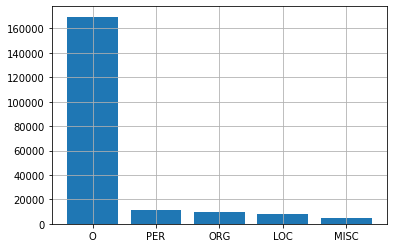

Valid distribution


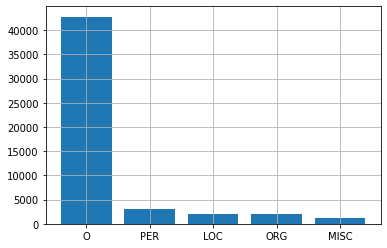

In [11]:
print("Train distribution")
visualize_distr(train_distribution)
print("Valid distribution")
visualize_distr(valid_distribution)

Defining class for a map-style dataset

In [12]:
class NERDataset(Dataset):

  def __init__(self, data):
    self.sentence = data['sentences']
    self.labels = data['labels_per_sent']

  def __getitem__(self, index):
    return {'sentence': self.sentence[index], 
            'labels': self.labels[index]}

  def __len__(self):
    return len(self.labels)

train_dataset = NERDataset(train)
valid_dataset = NERDataset(valid)

In [13]:
tag2idx = {'PAD': 0, 'LOC': 1, 'MISC': 2, 'O': 3, 'ORG': 4, 'PER': 5}

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Defining helper functions to process data before submitting them for training, validation and testing.

In [15]:
def tokenize_and_preserve_labels(sentence, text_labels):
    """ from https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/ """
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)

        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


def labels_to_idx(labels):
    return list(itertools.chain.from_iterable([[0], [tag2idx[i] for i in labels], [0]]))


def get_padded(values):
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [0]*(max_len-len(value)) for value in values])

    return padded


def collate_fn(batch):
    inp = []
    labels = []
    for elem in batch:
        tokenized_inputs, lbls = tokenize_and_preserve_labels(elem['sentence'], elem['labels'])
        inp.append(tokenizer.encode_plus(tokenized_inputs, 
                                         None, 
                                         add_special_tokens=True, 
                                         return_token_type_ids=False)['input_ids'])
        labels.append(labels_to_idx(lbls))

    inputs = get_padded(inp) 
    labels = get_padded(labels)
    attention_mask = get_padded([[1 for i in elem] for elem in inp]) 

    return {"inputs": torch.tensor(inputs), "labels": torch.LongTensor(labels), 'attention_mask': torch.tensor(attention_mask)}


def transform_logits(predictions: torch.tensor):
  predictions = predictions.tolist()
  logits2idx = []
  logits2idx.extend([list(p) for p in np.argmax(predictions, axis=2)])
  transformed_logits = []
  for elem in logits2idx:
    transformed_logits.append(list(itertools.chain.from_iterable([[key for (key, value) in tag2idx.items() if value==i] for i in elem]))[1:])
  return transformed_logits


def transform_target(target_labels: torch.tensor):
  target_labels = target_labels.tolist()
  transformed_target = []
  for elem in target_labels:
    transformed_target.append(list(itertools.chain.from_iterable([[key for (key, value) in tag2idx.items() if value==i] for i in elem]))[1:])
  return transformed_target


def count_metrics(gold_labels_per_sentence: List[List[str]], predict_labels_per_sentence: List[List[str]]):
  gold_labels = [l for l_per_sent in gold_labels_per_sentence for l in l_per_sent]
  predict_labels = [l for l_per_sent in predict_labels_per_sentence for l in l_per_sent]
  print(classification_report(gold_labels, predict_labels))


def predict_preprocessing(gold_labels: List[str], predicted_labels: List[str]):
  processed_predict = []
  for i in range(len(gold_labels)):
    sent_len = len(gold_labels[i])
    processed_predict.append(predicted_labels[i][:sent_len])
  return processed_predict

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

Loading pre-trained BertForTokenClassification model

In [17]:
pretrained_model = BertForTokenClassification.from_pretrained( "bert-base-cased",
                                                               num_labels=len(tag2idx),
                                                               output_attentions = False,
                                                               output_hidden_states = False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Defining class of simple NERmodel with pre-trained BertForTokenClassification inside.

In [18]:
class NERModel(nn.Module):

  def __init__(self, pretrained_model):
    super().__init__()
    
    self.bert = pretrained_model

  def forward(self, inputs, attention_mask=None, labels=None, token_type_ids=None):
    outputs = self.bert(inputs,
                        token_type_ids=token_type_ids,
                        attention_mask=attention_mask,
                        labels=labels)

    return outputs

In [19]:
device = "cuda:0"

In [20]:
model = NERModel(pretrained_model)
model = model.to(device)

Set model params

In [21]:
param_optimizer = list(model.bert.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                                 'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                                 'weight_decay_rate': 0.0}]

optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5, eps=1e-8)

Model training and validation

In [22]:
losses = {"train_losses": [], "valid_losses": []}

epochs = 3
CLIP = 1.0
best_valid_loss = np.inf

for epoch in range(epochs):

  print(f"Start eposh #{epoch}")
  
  train_loss_sum = 0
  model.train()
  for i, train_batch in enumerate(train_dataloader):
    torch.cuda.empty_cache()
    inp = train_batch['inputs'].to(device)
    lbls = train_batch['labels'].to(device)
    attn = train_batch['attention_mask'].to(device)

    optimizer.zero_grad()

    outputs = model.forward(inp, attention_mask=attn, labels=lbls)

    loss = outputs.loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(parameters=model.bert.parameters(), max_norm=CLIP)
    optimizer.step()

    train_loss_sum += loss.cpu().detach().numpy().item()

  losses["train_losses"].append(train_loss_sum/(i+1))

  predict_labels, gold_labels = [], []

  val_loss_sum = 0
  model.eval()
  with torch.no_grad():
    for i, valid_batch in enumerate(valid_dataloader):
      torch.cuda.empty_cache()
      inp = valid_batch['inputs'].to(device)
      lbls = valid_batch['labels'].to(device)
      attn = valid_batch['attention_mask'].to(device)

      outputs = model.forward(inp, attention_mask=attn, labels=lbls)
      loss = outputs.loss
      logits = outputs.logits

      val_loss_sum += loss.cpu().detach().numpy().item()
      gold_labels.append(transform_target(valid_batch["labels"]))
      predict_labels.append(transform_logits(logits.cpu()))

  losses["valid_losses"].append(val_loss_sum/(i+1))

  if losses["valid_losses"][-1] < best_valid_loss:
    best_valid_loss = losses["valid_losses"][-1]
    torch.save(model.state_dict(), 'best-val-model.pt')

  gold_labels = list(itertools.chain.from_iterable(gold_labels))
  gold_labels = [[x for x in elem if x !='PAD'] for elem in gold_labels]
  predict_labels = list(itertools.chain.from_iterable(predict_labels))
  predict_labels = predict_preprocessing(gold_labels, predict_labels)
  
  count_metrics(gold_labels, predict_labels)
  
  print(f"End eposh #{epoch}")

Start eposh #0
              precision    recall  f1-score   support

         LOC       0.95      0.96      0.95      4016
        MISC       0.86      0.88      0.87      2071
           O       0.99      1.00      0.99     51723
         ORG       0.97      0.89      0.93      3781
         PER       0.98      0.98      0.98      6357

    accuracy                           0.98     67948
   macro avg       0.95      0.94      0.94     67948
weighted avg       0.98      0.98      0.98     67948

End eposh #0
Start eposh #1
              precision    recall  f1-score   support

         LOC       0.95      0.96      0.96      4016
        MISC       0.89      0.88      0.88      2071
           O       0.99      1.00      0.99     51723
         ORG       0.98      0.91      0.94      3781
         PER       0.98      0.98      0.98      6357

    accuracy                           0.99     67948
   macro avg       0.96      0.95      0.95     67948
weighted avg       0.99      0.99 

In [23]:
print('Model validation f1_score: {0:.6f}'.format(f1_score(gold_labels, predict_labels)))
print('Model validation accuracy: {0:.6f}'.format(accuracy_score(gold_labels, predict_labels)))

Model validation f1_score: 0.946223
Model validation accuracy: 0.986401


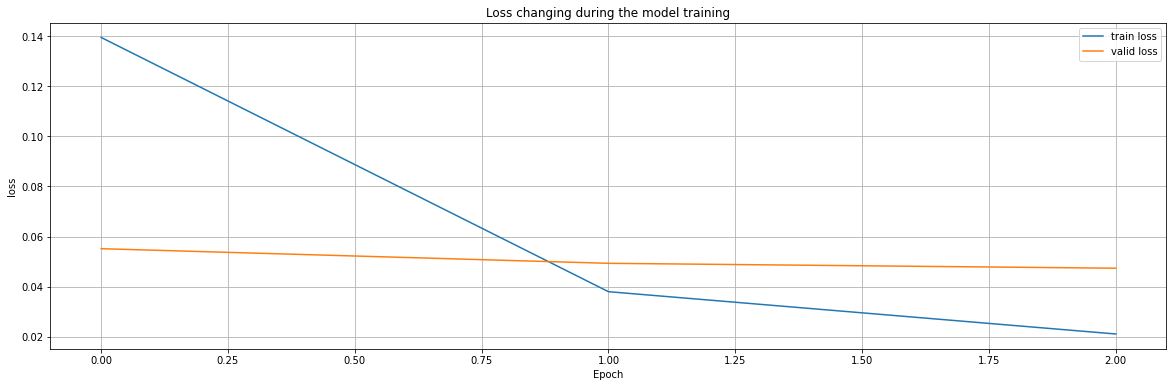

In [24]:
plt.rcParams["figure.figsize"] = (20,6)
plt.plot(losses["train_losses"], label='train loss')
plt.plot(losses["valid_losses"], label='valid loss')
plt.grid(True)
plt.title('Loss changing during the model training')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show();

Defining function for model testing and test example visualization.

In [25]:
def show_example(sentence, tokenizer, model):
  """ from https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/ """  
  tokenized_sentence = tokenizer.encode(sentence)
  input_ids = torch.tensor([tokenized_sentence]).cuda()

  model.eval()
  with torch.no_grad():
    output = model(input_ids)

  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append([key for (key, value) in tag2idx.items() if value==label_idx])
          new_tokens.append(token)

  new_labels = list(itertools.chain.from_iterable(new_labels))
  for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

Testing model

In [26]:
best_model = NERModel(pretrained_model).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))

<All keys matched successfully>

In [27]:
test_sentence = """
In a flier distributed on Capitol Hill last week, Elon Musk’s SpaceX warned that 
legislation now being considered would reward “Jeff Bezos with a $10 billion 
sole-source hand-out” that would tie up NASA’s moon plans and hand “space leadership to China.” 
"""

show_example(test_sentence, tokenizer, best_model)

PAD	[CLS]
O	In
O	a
O	flier
O	distributed
O	on
LOC	Capitol
LOC	Hill
O	last
O	week
O	,
ORG	Elon
ORG	Musk
O	’
O	s
ORG	SpaceX
O	warned
O	that
O	legislation
O	now
O	being
O	considered
O	would
O	reward
O	“
PER	Jeff
PER	Bezos
O	with
O	a
O	$
O	10
O	billion
O	sole
O	-
O	source
O	hand
O	-
O	out
O	”
O	that
O	would
O	tie
O	up
ORG	NASA
O	’
O	s
O	moon
O	plans
O	and
O	hand
O	“
O	space
O	leadership
O	to
LOC	China
O	.
O	”
PAD	[SEP]
